# Cutting stock problem (1d)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import linprog

from bnbprob.milpy.colgen import ColGenMILP, MILPColumn, MILPDuals
from bnbpy import BranchAndBound, PriceSol, Pricing, configure_logfile

## Master Problem

$$
 \begin{align}
     \text{min} \quad & \sum_{p \in P} c_{p} x_{p} \\
     \text{s.t} \quad & d_{i} \leq \sum_{p \in P} a_{i, p} x_{p} & \forall \; i \in I \\
     & x_{p} \geq 0 & \forall \; p \in P \\
     & x_{p} \in \mathbb{Z} & \forall \; p \in P
 \end{align}
 $$


 ## Pricing Problem

 $$
 \begin{align}
     \text{max} \quad & \sum_{i \in I} \pi_{i} y_{i} \\
     \text{s.t} \quad & \sum_{i \in I} w_{i} y_{i} \leq W\\
     & y_{i} \geq 0 & \forall \; i \in I \\
     & y_{i} \in \mathbb{Z} & \forall \; i \in I
 \end{align}
 $$

In [2]:
configure_logfile("cutting-stock.log", mode="w")

In [3]:
def solve_knapsack(
    capacity: float,
    weights: np.ndarray,
    costs: np.ndarray
):
    return linprog(
        -costs,
        A_ub=np.atleast_2d(weights),
        b_ub=np.atleast_1d(capacity),
        bounds=(0, None),
        integrality=1,
    )


class KnapsackPricing(Pricing):
    def __init__(self, capacity: float, weights: np.ndarray, price_tol=0.01):
        super().__init__(price_tol)
        self.capacity = capacity
        self.weights = weights
        self.c = None

    def set_weights(self, c: MILPDuals):
        # Check if master problem was feasible (therefore we have duals)
        if c.ineqlin is None:
            self.c = None
            return
        self.c = -c.ineqlin

    def solve(self) -> PriceSol:
        # If master problem was not feasible, return an empty price solution
        if self.c is None:
            return PriceSol(float('inf'), None)
        # Otherwise solve knapsack
        sol = solve_knapsack(self.capacity, self.weights, self.c)
        new_col = MILPColumn(a_ub=-sol.x, c=1.0, bounds=(0, None))
        return PriceSol(1 + sol.fun, new_col)

In [4]:
class CuttingStock(ColGenMILP):
    def __init__(
        self,
        total_width: float,
        w: np.ndarray,
        d: np.ndarray,
        price_tol: float = 1e-2,
        **kwargs,
    ):
        """Cutting stock problem

        Parameters
        ----------
        total_width : float
            Total width of 1d piece (in the equation $W$)

        w : np.ndarray
            Width of each individual demand (in the equation $w_j$)

        d : np.ndarray
            Total demand for each piece (in the equation $d_j$)

        price_tol : float, optional
            Tolerance in pricing problem, by default 1e-2
        """
        pricing = KnapsackPricing(total_width, w, price_tol=price_tol)
        A = np.eye((len(w))) * (total_width // w)
        c = np.ones_like(w)
        super().__init__(
            c,
            A_ub=-A,
            b_ub=-d,
            bounds=(0, None),
            integrality=1,
            pricing=pricing,
            **kwargs,
        )

    def calc_bound(self):
        f = super().calc_bound()
        if f < float('inf'):
            return int(round(f, 2))
        return f

In [5]:
total_width = 100.0

# Instance from https://jump.dev/JuMP.jl/stable/tutorials/algorithms/cutting_stock_column_generation/
dataset = pd.read_csv('../data/cut-stock/data.txt', sep=' ')


problem = CuttingStock(
    total_width, dataset.w.values, dataset.d.values, price_tol=1e-2
)
bnb = BranchAndBound()
sol = bnb.solve(problem)
print(sol)

Status: OPTIMAL | Cost: 334.0 | LB: 334.0


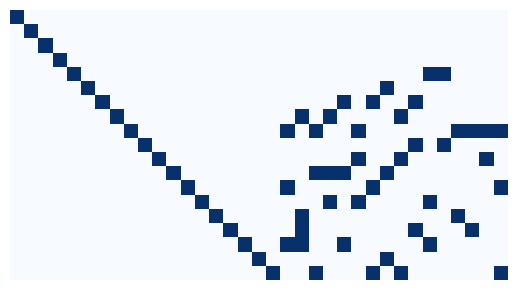

In [6]:
fig, ax = plt.subplots(figsize=[7, 3], dpi=100)
hmap = ax.imshow(-sol.problem.A_ub > 1e-6, cmap="Blues")
plt.axis('off')
fig.tight_layout()
plt.show()